In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from funk_svd.dataset import fetch_ml_ratings
from funk_svd import SVD
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# Load User Data

In [4]:
user_data = pd.read_csv('ml-100k/u.user' , sep='|', header=None , names=["uid", "age", "sex" ,"job", "zipcode"])
#user_data.describe()
print(user_data.head())

   uid  age sex         job zipcode
0    1   24   M  technician   85711
1    2   53   F       other   94043
2    3   23   M      writer   32067
3    4   24   M  technician   43537
4    5   33   F       other   15213


# Load Movie Data

In [5]:
movies_data = pd.read_csv('ml-100k/u.item' , sep='|', header=None , names=["movieid", "title" ,"release_date", "video_release_date", "imdb", "unknown", "action", "adventure", "animation", "children", "comedy", "crime", "documnetary", "drama", "fantasy", "noir", "horror", "musical", "mistery", "romance", "scifi", "thriller", "war", "western"])
print(movies_data.head())

   movieid              title release_date  video_release_date  \
0        1   Toy Story (1995)  01-Jan-1995                 NaN   
1        2   GoldenEye (1995)  01-Jan-1995                 NaN   
2        3  Four Rooms (1995)  01-Jan-1995                 NaN   
3        4  Get Shorty (1995)  01-Jan-1995                 NaN   
4        5     Copycat (1995)  01-Jan-1995                 NaN   

                                                imdb  unknown  action  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...        0       0   
1  http://us.imdb.com/M/title-exact?GoldenEye%20(...        0       1   
2  http://us.imdb.com/M/title-exact?Four%20Rooms%...        0       0   
3  http://us.imdb.com/M/title-exact?Get%20Shorty%...        0       1   
4  http://us.imdb.com/M/title-exact?Copycat%20(1995)        0       0   

   adventure  animation  children  ...  fantasy  noir  horror  musical  \
0          0          1         1  ...        0     0       0        0   
1          1    

# Load Ratings Data

In [6]:
# Ratings
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']

ratings = pd.read_csv("ml-100k/u.data", sep="\t", names=r_cols, encoding='latin-1')

print(ratings.head())

   user_id  movie_id  rating  timestamp
0      196       242       3  881250949
1      186       302       3  891717742
2       22       377       1  878887116
3      244        51       2  880606923
4      166       346       1  886397596


# Sparsity

The Sparsity of a matrix is measured by the number of cells that do not have a value (meaning . As it can be seen below, the matrix of ratings in this dataset is going to be very sparse, having a sparsity of 93.7%, which means that the majority of users only rated a small percentage of the movies.

In [7]:
sparsity = 1 - len(ratings) / (len(user_data) * len(movies_data))
print(f"Sparsity: {sparsity:.3f}")

Sparsity: 0.937


# Data Analysis

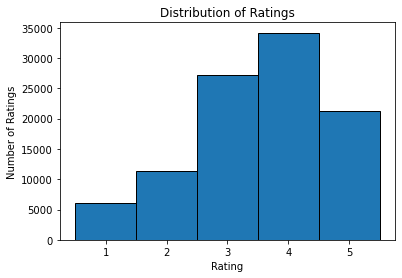

In [10]:
plt.hist(ratings.rating, ec='black', bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5])
plt.xlabel("Rating")
plt.ylabel("Number of Ratings")
plt.title("Distribution of Ratings")
plt.xticks([1, 2, 3, 4, 5])
plt.show()

# Construct Matrix

In [11]:
ratings_matrix = ratings.pivot(index="user_id", columns="movie_id", values="rating")

print(ratings_matrix.shape)
print(ratings_matrix.iloc[:5, :5])


(943, 1682)
movie_id    1    2    3    4    5
user_id                          
1         5.0  3.0  4.0  3.0  3.0
2         4.0  NaN  NaN  NaN  NaN
3         NaN  NaN  NaN  NaN  NaN
4         NaN  NaN  NaN  NaN  NaN
5         4.0  3.0  NaN  NaN  NaN


As it can be seen above, there are NaN entries on the matrix, which need to be replaced by some other value in order to perform the approach we intend to use.

There are several approaches to this problem, such as replacing with zero value, or average of all ratings, or even the average rating of a user.

In [12]:
mean_rating = np.mean(ratings.rating)
print(mean_rating)
ratings_matrix_mean = ratings_matrix.fillna(mean_rating)
print(ratings_matrix_mean.iloc[:5, :5])

ratings_matrix = ratings_matrix.fillna(0)
print(ratings_matrix.iloc[:5, :5]) #this is the matrix we will use henceforth

3.52986
movie_id        1        2        3        4        5
user_id                                              
1         5.00000  3.00000  4.00000  3.00000  3.00000
2         4.00000  3.52986  3.52986  3.52986  3.52986
3         3.52986  3.52986  3.52986  3.52986  3.52986
4         3.52986  3.52986  3.52986  3.52986  3.52986
5         4.00000  3.00000  3.52986  3.52986  3.52986
movie_id    1    2    3    4    5
user_id                          
1         5.0  3.0  4.0  3.0  3.0
2         4.0  0.0  0.0  0.0  0.0
3         0.0  0.0  0.0  0.0  0.0
4         0.0  0.0  0.0  0.0  0.0
5         4.0  3.0  0.0  0.0  0.0


# SVD

The SVD, Singular Value decomposition, its a technique that allows the factorization of the matrix data into a multiplication between three matrices, U, Sigma and V. The columns of the matrix U are considered the singular vectors on the left and the columns of the matrix V are the singular vectors on the right. Sigma has the singular values diagonally. SVD contains some important properties:

    - It is always possible to decompose any matrix A into three matrices: U, Sigma and V.
    - U, Sigma and V are always unique matrices, which means that a set of U, Sigma and V represents a single matrix A.
    - U and V have orthonormal columns, which means that by multiplying the transpose of U with U, an identity matrix is ​​obtained.
    - The sigma matrix is diagonal, which means that all non-diagonal values have zero value. The diagonal entries of this matrix are always positive, and by convention they are sorted in descending order.


In [13]:
#TODO:
# Get a few data for tests and then replace on train matrix
# also do ratings_matrix = ratings_matrix.fillna(x) with x equal to the mean global rating
# and then predict for a trained rating and untrained rating

U, S, VT = np.linalg.svd(ratings_matrix, full_matrices=False)

print("Matrices for ratings")
print(f"U: {pd.DataFrame(U).iloc[:5, :5]}")
print(f"S: {pd.DataFrame(S).iloc[:5, :]}")
print(f"VT: {pd.DataFrame(VT).iloc[:5, :5]}")
print(U.shape)
print(S.shape)
print(VT.shape)


U:           0         1         2         3         4
0 -0.065804  0.005975 -0.006133  0.084347 -0.014188
1 -0.014021 -0.046626  0.052579 -0.016282  0.015467
2 -0.005658 -0.025618  0.023362 -0.028564 -0.044057
3 -0.005993 -0.020698  0.012452 -0.019697 -0.025116
4 -0.032747  0.009159 -0.046131  0.014407 -0.010518
S:             0
0  640.633623
1  244.836346
2  217.846225
3  159.153599
4  158.211914
VT:           0         1         2         3         4
0 -0.095951 -0.035180 -0.019929 -0.059952 -0.021607
1 -0.087240 -0.007025 -0.028618  0.013050 -0.015311
2 -0.016974 -0.062504 -0.011641 -0.026446 -0.026460
3  0.016206  0.003234  0.048801  0.043000  0.017901
4  0.140506 -0.040758 -0.004402 -0.038221 -0.015655
(943, 943)
(943,)
(943, 1682)
